In [50]:
import os
import glob
import random
import time
import math
import string
import unicodedata

import torch
from torch import nn
import seaborn as sns

from matplotlib import pyplot as plt

### Download the data and unzip data

In [51]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip -q data.zip

--2024-06-02 11:55:08--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 108.158.61.105, 108.158.61.54, 108.158.61.49, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.158.61.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2024-06-02 11:55:08 (76.6 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [52]:
DATASET_PATH = "data/names"
FILES_LIST = glob.glob("data/names/*")
FILES_LIST

['data/names/Czech.txt',
 'data/names/French.txt',
 'data/names/Italian.txt',
 'data/names/Dutch.txt',
 'data/names/Arabic.txt',
 'data/names/Russian.txt',
 'data/names/Polish.txt',
 'data/names/Scottish.txt',
 'data/names/Greek.txt',
 'data/names/Spanish.txt',
 'data/names/Chinese.txt',
 'data/names/Japanese.txt',
 'data/names/Portuguese.txt',
 'data/names/English.txt',
 'data/names/Irish.txt',
 'data/names/Vietnamese.txt',
 'data/names/German.txt',
 'data/names/Korean.txt']

In [53]:
all_letters = string.ascii_letters + " .,;'"
N_LETTERS = len(all_letters)

print("Total valid ascii letters: %s" %N_LETTERS)
print("Valid letters : %s" %all_letters)

Total valid ascii letters: 57
Valid letters : abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'


### **unicode_to_ascii**

Learn more about Unicode and Normalization: [UNICODE NORMALIZATION FORMS](https://unicode.org/reports/tr15/)
1. `unicodedata.normalize("NFD", string)`: This uses the `normalize` function from the `unicodedata` module to apply the Normal Form D (NFD) decomposition to the input `string`. NFD decomposes characters with diacritics into their base character and combining diacritics.

2. `c for c in ...`: This is a list comprehension. It iterates over each character `c` in the result of the NFD decomposition.

3. `if unicodedata.category(c) != "Mn" and c in all_letters`: This is a conditional statement that filters the characters. It checks two conditions:
   - `unicodedata.category(c) != "Mn"`: This checks if the character `c` is not in the "Mark, Nonspacing" category. This category typically includes diacritics or combining characters.
   - `c in all_letters`: This checks if the character `c` is in a collection called `all_letters`. This collection likely contains all the valid letters.

4. `"".join(...)`: This combines the filtered characters back into a string. It joins each character with an empty string, effectively concatenating them.

In [54]:
def unicode_to_ascii(string: str):
  """
  Convert a Unicode string to plain ASCII.

  This function uses Normal Form D (NFD) which translates each character 
  into its decomposed form. It then removes any non-ASCII characters and 
  retains only those found in the `all_letters` set.

  Args:
      string (str): The Unicode string to be converted.

  Returns:
      str: The converted string with only ASCII characters.
  """
  return "".join(
      c for c in unicodedata.normalize("NFD", string)
      if unicodedata.category(c) != "Mn" and c in all_letters
  )

In [55]:
all_categories = []
category_lines = {}
if os.path.exists(DATASET_PATH) and os.path.isdir(DATASET_PATH):
  file_list = os.listdir(DATASET_PATH)
  all_categories = [category.replace(".txt", "")
                      for category in file_list]

N_CATEGORIES = len(all_categories)

### **Read file**

In [56]:
def read_lines(filename: str):
  """
  Read a file and convert its contents to ASCII.

  This function reads the specified file, processes each line to convert it 
  from Unicode to ASCII using the `unicode_to_ascii` function, and returns 
  a list of the converted lines.

  Args:
    filename (str): The path of the file to be read.

  Returns:
    list: A list of strings, each converted to ASCII.
  """
  with open(filename, encoding="utf-8") as fp:
    lines = fp.read().strip().split('\n')
  return [unicode_to_ascii(line) for line in lines]

In [57]:
all_categories = []
for filename in FILES_LIST:
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = read_lines(filename)
  category_lines[category] = lines

print("total number of categories %s" % len(all_categories))

total number of categories 18


In [58]:
print(category_lines["Greek"][:5])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']


In [59]:
def letter_to_index(letter: str):
  """
  Convert a letter to its corresponding index.

  This function finds the index of a given letter in the `all_letters` set.

  Args:
    letter (str): A single character.

  Returns:
    int: The index of the letter in the `all_letters` set.
  """
  return all_letters.find(letter)

def letter_to_tensor(letter: str):
  """
  Convert a letter to a one-hot encoded tensor.

  This function creates a tensor of size (1, N_LETTERS) where the position 
  corresponding to the letter's index is set to 1.

  Args:
    letter (str): A single character.

  Returns:
    torch.Tensor: A one-hot encoded tensor representing the letter.
  """
  tensor = torch.zeros(1, N_LETTERS)
  tensor[0][letter_to_index(letter)] = 1
  return tensor

# lets see index of letter `q`
letter_to_index("q")

16

In [60]:
def line_to_tensor(line: str):
  """
  Convert a line of text to a tensor.

  This function creates a tensor of size (len(line), 1, N_LETTERS) where 
  each character in the line is represented by a one-hot encoded vector.

  Args:
    line (str): A string of text.

  Returns:
    torch.Tensor: A tensor representing the line of text with one-hot encoded vectors for each character.
  """
  tensor = torch.zeros(len(line), 1, N_LETTERS)
  for li, letter in enumerate(line):
    tensor[li][0][letter_to_index(letter)] = 1
  return tensor

In [61]:

test_text = "Tthisaaa is it"
tensor_of_test_text = line_to_tensor(test_text)
print(f"Len of test_text: {len(test_text)}")
print(f"Shape of the tensor converted from test_text: {tensor_of_test_text.size()}")

Len of test_text: 14
Shape of the tensor converted from test_text: torch.Size([14, 1, 57])


In [62]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.layer1 = nn.Linear(input_size + hidden_size, hidden_size)
    self.layer2 = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.layer1(combined)
    output = self.layer2(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, N_CATEGORIES)

In [63]:
input_tensor  = letter_to_tensor("A")
hidden = torch.zeros(1, n_hidden)

output, next = rnn(input_tensor, hidden)

In [64]:
def category_from_output(output):
  """
  Determine the category from a model's output.

  This function takes the output of a model, finds the category with the 
  highest probability, and returns the category name along with its index.

  Args:
    output (torch.Tensor): The model's output tensor.

  Returns:
    tuple: A tuple containing the category name (str) and the category index (int).
  """
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i


print(category_from_output(output))

('German', 16)


In [65]:
def random_choice(L):
  return L[random.randint(0, len(L) -1)]

In [66]:
def random_training_example():
  # select one random category of language. -> str
  category = random_choice(all_categories)
  # select one line(Name) from choosen category randomly ->str
  line = random_choice(category_lines[category])

  # convert category to label -> dtype: `long` required for operation
  category_tensor = torch.tensor([all_categories.index(category)],
                                 dtype=torch.long)
  line_tensor = line_to_tensor(line)
  return category, line, category_tensor, line_tensor


In [67]:
category, line, category_tensor, line_tensor = random_training_example()
print(f"category: {category} | line: {line} \
| category_tensor: {category_tensor} | line_tensor: {line_tensor.shape}")

category: Czech | line: Michalovic | category_tensor: tensor([0]) | line_tensor: torch.Size([10, 1, 57])


In [68]:
def time_since(prev_time):
  """
  Calculate the time elapsed since a given previous time.

  This function returns the difference between the current time and the 
  provided previous time in minutes and seconds.

  Args:
    prev_time (float): The previous time (typically obtained using `time.time()`).

  Returns:
    tuple: A tuple containing the elapsed time in minutes (int) and seconds (int).
  """
  now = time.time()
  elapsed_seconds = now - prev_time
  minutes = math.floor(elapsed_seconds / 60)
  seconds = int(elapsed_seconds - minutes * 60)
  return minutes, seconds

### NLLLoss

The Negative Log Likelihood (NLL) Loss is a loss function commonly used for training classification models with multiple classes. Here's a detailed explanation:

#### Concept:
NLL Loss is particularly useful when you have a classification problem involving $ C $ classes. It measures how well your model's predicted probabilities match the true class labels. The goal during training is to minimize this loss, which means your model's predictions are becoming more accurate.

#### Input Expectations:
When you use NLLLoss, the input to the forward pass must be the log-probabilities of each class. This input should be in the form of a Tensor with one of the following shapes:

1. **For a standard minibatch:**
   $$
   (\text{minibatch}, C)
   $$
   Here, each element in the minibatch is represented by $ C $ log-probabilities, one for each class.

2. **For higher-dimensional data:**
   $$
   (\text{minibatch}, C, d1, d2, ..., dK)
   $$
   where $ K \geq 1 $. This form is useful when dealing with inputs that have more than two dimensions, such as images or volumetric data. For instance, if you are working with 2D images, your input might be of shape $(\text{minibatch}, C, \text{height}, \text{width})$. This allows the computation of NLL Loss on a per-pixel basis for each image in the minibatch.

In [69]:
learning_rate = 0.005
loss_fn = nn.NLLLoss()

def train(category_tensor, line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)
  loss = loss_fn(output, category_tensor)
  loss.backward()

  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)

  return output, loss.item()

In [70]:
n_iters = 200000
print_every = 10000
plot_every = 2000

# Track the loss
current_loss = 0
all_losses = []

start = time.time()

for step in range(1, n_iters + 1):
  category, line, category_tensor, line_tensor = random_training_example()
  output, loss = train(category_tensor, line_tensor)
  current_loss += loss

  if step % print_every == 0:
    guess, guess_i = category_from_output(output)
    correct = "✓" if guess == category else f"✗ ({category})"
    time_percent = step / n_iters * 100
    time_since_start = time_since(start)
    print(f"{iter} | {time_percent:.2f}% | ({time_since_start[0]:.2f}s, {time_since_start[1]:.2f}s) \
    | {loss:.4f} | {line} | {guess} | {correct}")

  if step % plot_every == 0:
    all_losses.append(current_loss / plot_every)
    current_loss = 0


134764 | 5.00% | (0.00s, 9.00s)     | 2.3729 | Kouri | Italian | ✗ (Arabic)
134764 | 10.00% | (0.00s, 18.00s)     | 2.2420 | Steube | French | ✗ (German)
134764 | 15.00% | (0.00s, 28.00s)     | 1.8404 | Daviau | Japanese | ✗ (French)
134764 | 20.00% | (0.00s, 38.00s)     | 1.6206 | Luc | Chinese | ✗ (Vietnamese)
134764 | 25.00% | (0.00s, 47.00s)     | 0.6617 | Demas | Greek | ✓
134764 | 30.00% | (0.00s, 57.00s)     | 1.1307 | Vandroogenbroeck | Dutch | ✓
134764 | 35.00% | (1.00s, 6.00s)     | 0.3619 | Kanaan | Arabic | ✓
134764 | 40.00% | (1.00s, 16.00s)     | 0.4857 | Machado | Portuguese | ✓
134764 | 45.00% | (1.00s, 25.00s)     | 5.0253 | Craig | Korean | ✗ (Scottish)
134764 | 50.00% | (1.00s, 35.00s)     | 0.3228 | Kurofuji | Japanese | ✓
134764 | 55.00% | (1.00s, 44.00s)     | 3.9171 | Uerling | Vietnamese | ✗ (Czech)
134764 | 60.00% | (1.00s, 53.00s)     | 1.4244 | Marszaek | Czech | ✗ (Polish)
134764 | 65.00% | (2.00s, 3.00s)     | 1.5086 | Kennedy | Irish | ✗ (Scottish)
134764 

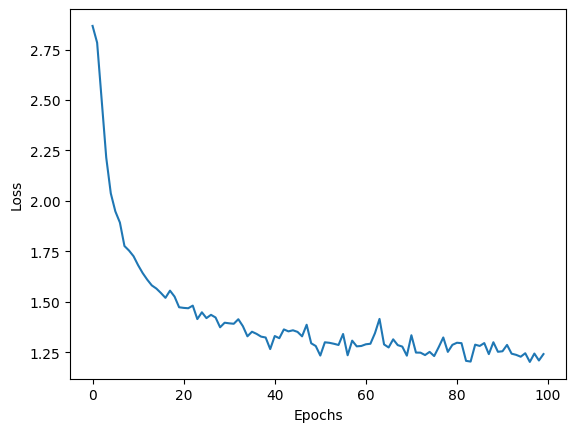

In [71]:
plt.figure()
plt.plot(all_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [72]:
confusion = torch.zeros(N_CATEGORIES, N_CATEGORIES)
n_confusion = 10000

def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  return output

In [73]:
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = random_training_example()
  output = evaluate(line_tensor)
  guess, guess_i = category_from_output(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] += 1

<Axes: >

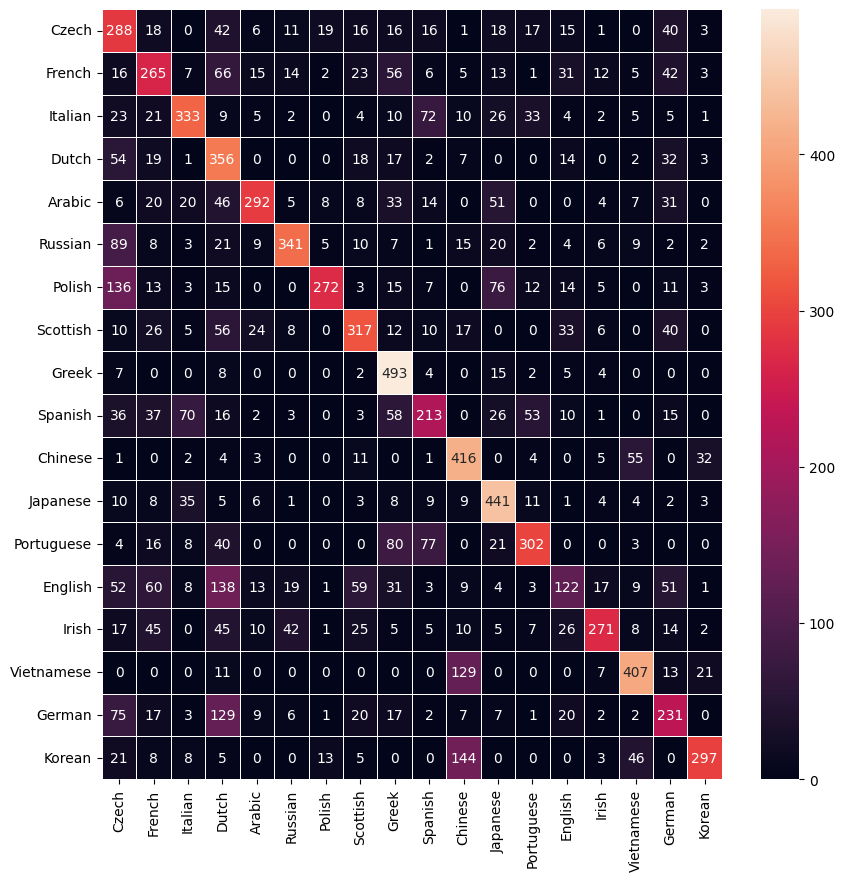

In [74]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=confusion.numpy(),
            xticklabels=all_categories,
            yticklabels=all_categories,
            annot=True,
            fmt=".0f",
            linewidth=.5)